<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#directions" data-toc-modified-id="directions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>directions</a></span></li><li><span><a href="#dataset-define" data-toc-modified-id="dataset-define-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>dataset define</a></span></li><li><span><a href="#transforms" data-toc-modified-id="transforms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>transforms</a></span></li><li><span><a href="#Dataloader" data-toc-modified-id="Dataloader-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dataloader</a></span></li><li><span><a href="#visulazation" data-toc-modified-id="visulazation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>visulazation</a></span></li><li><span><a href="#model-define" data-toc-modified-id="model-define-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>model define</a></span></li><li><span><a href="#model-training" data-toc-modified-id="model-training-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>model training</a></span></li></ul></div>

## imports

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import cv2

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)
%config Completer.use_jedi = False

## Functions

In [2]:
from Own_util.Visualizations import Visualizations,parse_arg

In [3]:
Trans = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

Normal = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

invTrans = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
                               transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
                               ])


In [30]:
def generate_grad_cam_inter(net,ori_image,label,criterion,num_classes = 1):
    """
    :param net: deep learning network(ResNet DataParallel object)
    :param ori_image: the original image
    :return: gradient class activation map
    """
    input_image = ori_image

    feature = None
    gradient = None

    def func_f(module, input, output):
        nonlocal feature
        feature = output.data.cpu().numpy()

    def func_b(module, grad_in, grad_out):
        nonlocal gradient
        gradient = grad_out[0].data.cpu().numpy()

    # net.module.layer4.register_forward_hook(func_f)
    # net.module.layer4.register_backward_hook(func_b)

    net.layer4.register_forward_hook(func_f)
    net.layer4.register_backward_hook(func_b)

#     pred = net(input_image.unsqueeze(0))
#     print(pred)
    out = net(input_image.unsqueeze(0))
    label = label.unsqueeze(0)
    
    if num_classes == 1:
        pred = out.data>0.5
    else:
        _, pred = torch.max(out.data, 1)

    net.zero_grad()

    loss = criterion(out,label)
#     loss = criterion(out,pred) # by the original, but maybe wrong. 
    loss.backward()

    feature = np.squeeze(feature, axis=0)
    gradient = np.squeeze(gradient, axis=0)

    weights = np.mean(gradient, axis=(1, 2), keepdims=True)

    cam = np.sum(weights * feature, axis=0)

    cam = cv2.resize(cam, (224, 224))
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    cam = 1.0 - cam
    cam = np.uint8(cam * 255)

    return cam

In [5]:
def localize(cam_feature, ori_image):
    """
    localize the abnormality region using grad_cam feature
    :param cam_feature: cam_feature by generate_grad_cam
    :param ori_image: the original image
    :return: img with heatmap, the abnormality region is highlighted
    """
    ori_image = np.array(ori_image)
    activation_heatmap = cv2.applyColorMap(cam_feature, cv2.COLORMAP_JET)
    activation_heatmap = cv2.resize(activation_heatmap, (ori_image.shape[1], ori_image.shape[0]))
    img_with_heatmap = 0.6 * np.float32(activation_heatmap) + 0.4 * np.float32(255*ori_image)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
    return img_with_heatmap

## directions

In [4]:
from distutils.dir_util import copy_tree


directory = r'E:\Xing\Kaggle_covid19\archive\COVID-19_Radiography_Dataset\Data'

source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID']
input_dir = 'train'
output_dir = 'test'
# root_dir = './train/covid19-radiography-database/COVID-19 Radiography Database'

In [5]:
# if os.path.isdir(os.path.join(directory, source_dirs[1])):
#     if not os.path.isdir(input_dir):
#         os.mkdir(input_dir)
#         copy_tree(directory, input_dir)
#     if not os.path.isdir(output_dir):
#         os.mkdir(output_dir)
        
#     for c in source_dirs:
#         if not os.path.isdir(os.path.join(output_dir, c)):
#             os.mkdir(os.path.join(output_dir, c))
            
#     for c in source_dirs:
#         images = [x for x in os.listdir(os.path.join(input_dir, c)) if x.lower().endswith('png')]
#         selected_images = random.sample(images, 30)
#         for image in selected_images:
#             source_path = os.path.join(input_dir, c, image)
#             target_path = os.path.join(output_dir, c, image)
#             shutil.move(source_path, target_path)
# else:
#     print('not a dir!')

## dataset define

In [6]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Normal', 'Viral', 'COVID-19']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

## transforms

In [7]:
#Creating a Transformation Object
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])
#Creating a Transformation Object
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
# We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

## Dataloader

In [8]:
train_dirs = {
    'Normal': input_dir + '/NORMAL',
    'Viral': input_dir + '/Viral Pneumonia',
    'COVID-19': input_dir + '/COVID'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 Normal examples
Found 1315 Viral examples
Found 3586 COVID-19 examples


In [9]:
test_dirs = {
    'Normal': output_dir + '/NORMAL',
    'Viral': output_dir + '/Viral Pneumonia',
    'COVID-19': output_dir + '/COVID'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 Normal examples
Found 30 Viral examples
Found 30 COVID-19 examples


In [10]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 2511
Num of test batches 15


## visulazation

In [11]:
# class_names = train_dataset.class_names

def show_images(images,labels, preds):
    plt.figure(figsize=(8,4))
    
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks =[]) # x & y ticks are set to blank
        image = image.numpy().transpose((1, 2, 0)) # Channel first then height and width
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [12]:
class_names = train_dataset.class_names

In [13]:
visual = Visualizations(class_names=class_names)

In [21]:
np.arange(4)

array([0, 1, 2, 3])

In [14]:
visual.class_names

['Normal', 'Viral', 'COVID-19']

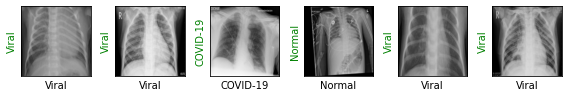

In [15]:
images, labels = next(iter(dl_train)) #Fetch the next batch of images
visual.show_images(images, labels, labels)

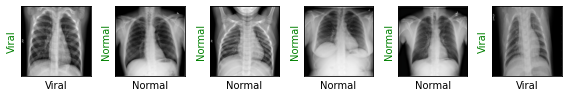

In [15]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [17]:
# run the model inital

In [24]:
def show_cam_images(model_ckpt, images, labels, preds, criteration,num_cls = 1):
    plt.figure(figsize=(8,4))
    
    for i, (ori_image,label) in enumerate(zip(images,labels)):
#         print(i,ori_image.shape,label)
        
        plt.subplot(1, 6, i + 1, xticks = [], yticks =[]) # x & y ticks are set to blank
        

#         ori_image = Image.open(args.img_path).convert('RGB')
        cam_feature = generate_grad_cam_inter(model_ckpt, ori_image, label,criteration,num_classes=num_cls)
#         print(cam_feature.shape)
        
        image = ori_image.numpy().transpose((1, 2, 0)) # Channel first then height and width
        
        image = localize(cam_feature, image)
        
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
        
    plt.tight_layout()
    plt.show()

In [16]:
images, labels = next(iter(dl_train)) #Fetch the next batch of images

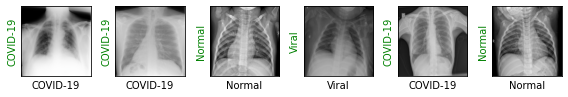

C:\Users\echang\Anaconda3\envs\fastai_v2\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


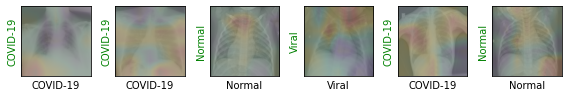

In [20]:
visual.show_images(images, labels, labels)
visual.show_cam_images(resnet18,255*images,labels,labels,loss_fn)

## model define

In [18]:
resnet18 = torchvision.models.resnet18(pretrained=True) #resnet18 is a small CNN that we can train quickly giving us decent results

In [19]:
#Changing the last fc to 3 output features

resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) #To find optimum learning rate 1. Trial/Error 2. Hyperparameter search

In [32]:
def show_preds():
    resnet18.eval()  #Setting the model to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
    show_cam_images(resnet18,images,labels,preds,loss_fn,num_cls=3)

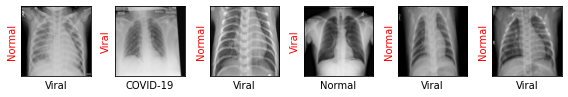

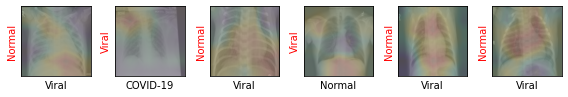

In [33]:
show_preds()

## model training

In [34]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.  #Not computing val_loss since we'll be evaluating the model multiple times within one epoch
        
        resnet18.train() # set model to training phase
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            #Once we get the loss we need to take a gradient step
            loss.backward() #Back propogation
            optimizer.step() #Completes the gradient step by updating all the parameter values(We are using all parameters)
            train_loss += loss.item() #Loss is a tensor which can't be added to train_loss so .item() converts it to float
            
            #Evaluating the model every 20th step
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) # 1 corresponds to the values and ) corresponds to the no of examples
                    accuracy += sum((preds == labels).numpy()) #adding correct preds to acc

                val_loss /= (val_step + 1) # 15 test batches so this logic gives the value for each step
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.99:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')


Starting training..
Starting epoch 1/10
Evaluating at step 0
Validation Loss: 1.4630, Accuracy: 0.2222


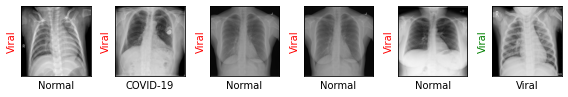

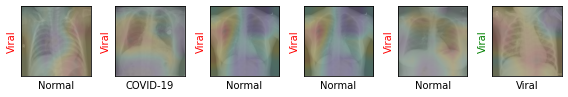

Evaluating at step 20
Validation Loss: 0.8416, Accuracy: 0.7111


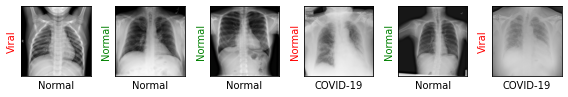

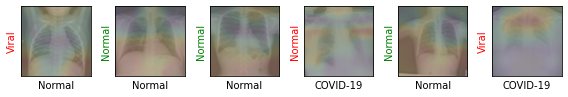

Evaluating at step 40
Validation Loss: 0.6746, Accuracy: 0.7111


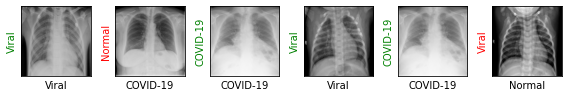

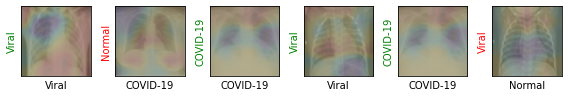

Evaluating at step 60
Validation Loss: 0.5490, Accuracy: 0.8333


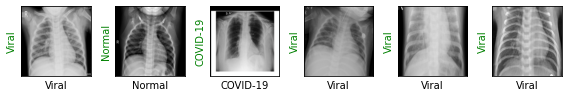

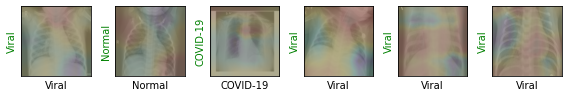

KeyboardInterrupt: 

In [35]:
%%time

train(epochs=10)